# Leaf Classification

The goal is to classify leaves based on their species/class given a number of attributes for each leaf.

The data was taken from the UCI Machine Learning Repository's "Leaf Data Set". It was created by Pedro F. B. Silva and AndrÃ© R. S. MarÃ§al using leaf specimens collected by Rubim Almeida da Silva at the Faculty of Science, University of Porto, Portugal.

Now import the data. We are told the features, sperate from the csv file, and so we must input them as column headers

In [1]:
# Data Analysis
import pandas as pd
from numpy import mean,std

# Training and Testing Sets
from sklearn.model_selection import train_test_split

# Logistic Regression - Classification Model
from sklearn.linear_model import LogisticRegression

# Cross Validating
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

# Scaling Features
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Pipeline
from sklearn.pipeline import Pipeline

# Confusion matrix and ROC plot
import scikitplot as skplt

# Booster
from sklearn.ensemble import AdaBoostClassifier

In [2]:
cols = ["Class (Species)","Specimen Number", "Eccentricity", "Aspect Ratio", "Elongation", "Solidity",
        "Stochastic Convexity", "Isoperimetric Factor","Maximal Indentation Depth", "Lobedness", 
        "Average Intensity", "Average Contrast", "Smoothness", "Third moment", "Uniformity", "Entropy"]

In [3]:
data  = pd.read_csv("leaf.csv",names = cols,index_col = False)

In [4]:
Target_col,Variables_col = cols[0],cols[1:]

In [5]:
X = data[Variables_col].to_numpy()
y = data[Target_col].to_numpy()

Now let us build a model. In this notebook we will apply classifcation via logistic regression, which in thise case will need to give us a multi-class target (>2 species). Due to the size of the dataset (small) and the multiple classes, we use the "Newton-Raphson" method to find the parameters that govern the classes.
***
***

### First I will apply this method without any feature adjustment/enginnering.

In order for this method to converge, I needed to adjust the maximum iterations from 100, so I chose 200. 

Notice that we have Classes (Species) 1-15, 22-36. This is because "Species numbered from 1 to 15
and from 22 to 36 exhibit simple leaves and species numbered from 16 to 21 and from 37 to 40 have complex leaves." from the data set's "Read Me" file. In this case, clearly we are only given species who exhibit simple leaf patterns

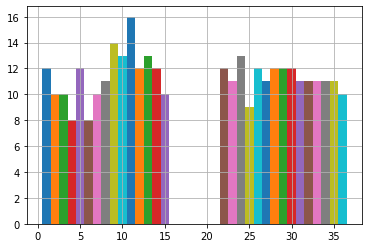

In [6]:
data.groupby(["Class (Species)"])["Class (Species)"].hist(bins = 1);

Notice that the target feature "Class" is imbalanced, hence RepeatedStratifiedKFold is used over RepeatedKFold when creating folds of the data for cross validation.

In [7]:
log_reg = LogisticRegression(penalty = 'none', solver = 'newton-cg', multi_class = 'multinomial', max_iter = 200)

I will perform the Logistic Regression on the data set split into standard test and training data. This will test how the model performs on the specific test set given the specific training set. It will also allow us to visualize our model performace through a confusion matrix.

Accuracy: 63.529% 


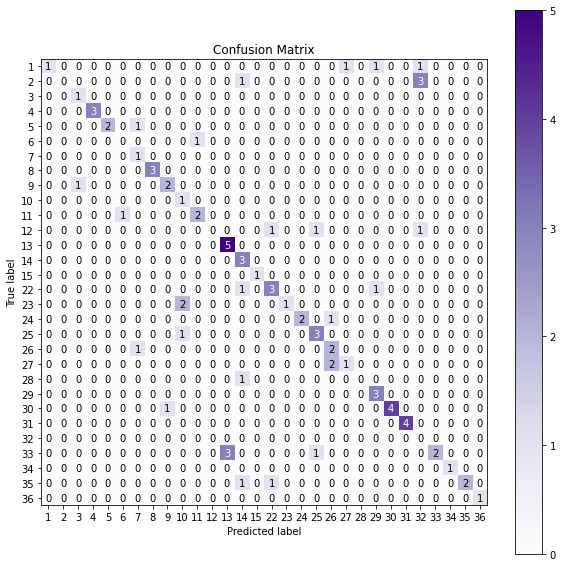

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

log_reg.fit(X_train,y_train) 

y_test_pred = log_reg.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test, y_test_pred,
                                    title="Confusion Matrix",
                                    cmap="Purples",figsize = (10,10));
print('Accuracy: %.3f%% ' % (log_reg.score(X_test,y_test)*100))

Now cross-validate the model to see how it improves with a better respresentation of the data set than the train/test split above

In [9]:
# When cross-validating we re-fit the model,overriding the previous fit, hence need not redefine it
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, random_state=1)
# evaluate the model
m_scores = cross_val_score(log_reg, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize the result
print('Accuracy: %.3f%% (%.3f)' % (mean(m_scores)*100, std(m_scores)))
acc_1 = mean(m_scores)

Accuracy: 69.710% (0.076)


As we can see, this model is decently good. Now, let's see if some feature engineering can improve this!
***
***

### Now I will apply the method after normalizing only non-Gaussian features and standardizing only Gaussian-like features.

Let's take a look at our features, so that we can indentify their probability density function shape

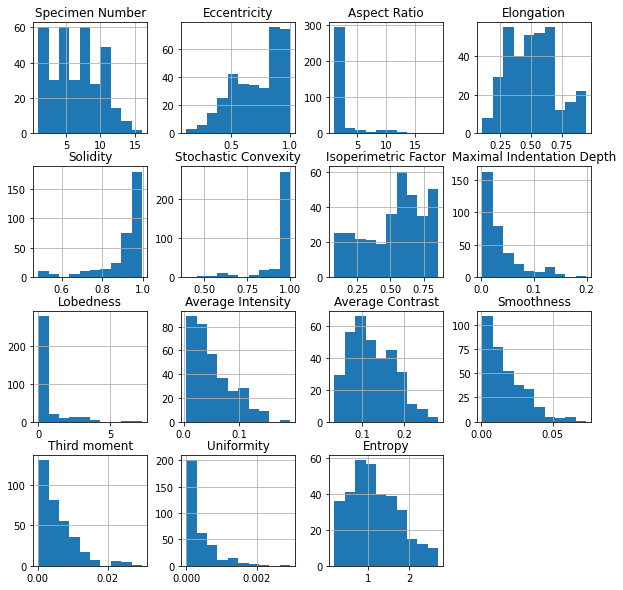

In [10]:
data[Variables_col].hist(figsize = (10,10));

I'm not sure what to do about "Specimen Number" or "Isoperimetric Factor". We can see that "Elongation","Average Constrast", and "Entropy" are all Gaussian-like. We can also see that the rest are exponential-like.

In [11]:
# define column indexes for the variables with "normal" and "exponential" distributions
idk_ix = [0,6]
norm_ix = [3,10,14]
exp_ix = [1,2,4,5,7,8,9,11,12,13,14]

In [12]:
# define the selective transforms
t = [('e', MinMaxScaler(), exp_ix), ('n', StandardScaler(), norm_ix)]
selective = ColumnTransformer(transformers=t)

In [13]:
# define the modeling pipeline
# When cross-validating we re-fit Logistic Regression,overriding the previous fit, hence need not redefine it
pipeline = Pipeline([('s',selective),('l',log_reg)])

Again, we first test model performance on the data set split into standard test and training data, and visualize this performance through a confusion matrix.

Accuracy: 63.529% 


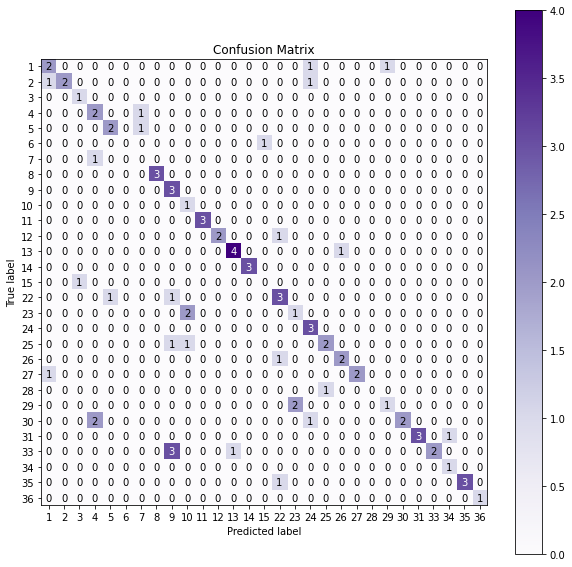

In [14]:
pipeline.fit(X_train,y_train) 

y_test_pred = pipeline.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test, y_test_pred,
                                    title="Confusion Matrix",
                                    cmap="Purples",figsize = (10,10));

print('Accuracy: %.3f%% ' % (pipeline.score(X_test,y_test)*100))

Now we plot the ROC curve using the whole data set instead of just the testing data set. We chose to do this because due to the small size of our data set, the test set does not contain examples of all the classes, nor is the predicted probability given for all the classes. 

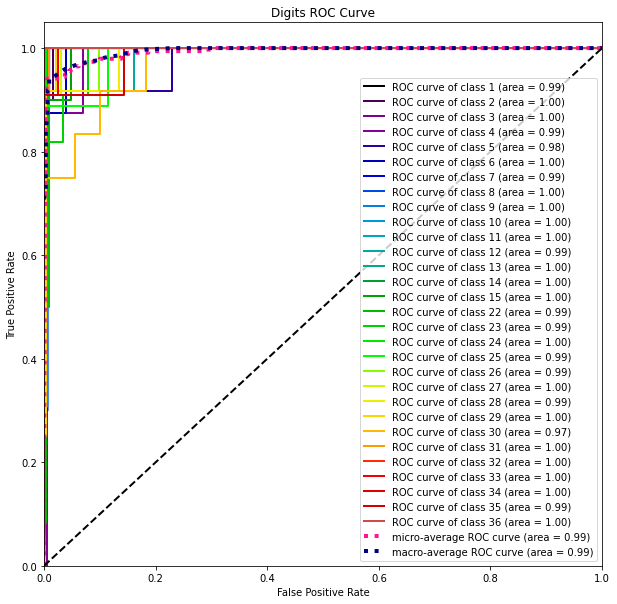

In [15]:
y_proba = pipeline.predict_proba(X)
skplt.metrics.plot_roc(y, y_proba,
                       title="Digits ROC Curve", figsize=(10,10));

Again, we cross validate to see how our model improves with a better respresentation of the data set than the train/test split above

In [16]:
# Define the evaluation procedure ()
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, random_state=2)
# evaluate the model
m_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize the result
print('Accuracy: %.4f%% (%.4f)' % (mean(m_scores)*100, std(m_scores)))
acc_2 = mean(m_scores)

Accuracy: 72.4529% (0.0545)


In [17]:
print('We have imporved our Accuracy by %.4f%% \nThis is a signifigant improvement!' %((acc_2-acc_1)*100))

We have imporved our Accuracy by 2.7432% 
This is a signifigant improvement!


In [18]:
X_ada = ColumnTransformer(transformers = t).fit_transform(X)
ada=AdaBoostClassifier(base_estimator = log_reg,n_estimators=200,random_state=0,learning_rate=0.1)
result=cross_val_score(ada,X_ada,y,cv=cv,scoring='accuracy')
print('The cross validated score for AdaBoost is: %.4f%%' % (result.mean()*100))

The cross validated score for AdaBoost is: 74.7024%
